In [1]:
# ----------------------------------------
# 1. GPU 屏蔽设置(对于两块适配不同cuada版本gpu使用，此部分可删去)
# ----------------------------------------

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
# ----------------------------------------
# 2. 导入库并检查环境
# ----------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import numpy as np
import matplotlib.pyplot as plt

# 导入 SpikingJelly 核心库
from spikingjelly.activation_based import neuron, functional, layer

# 导入 CIFAR10-DVS 数据集加载器
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS

# 导入 自定义的替代梯度函数
import my_surrogates

# 检查环境 (与 run_cifar10_snn 相同)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")

PyTorch version: 2.9.1+cu128
CUDA available: True
Current device: NVIDIA GeForce RTX 3090
Device count: 1


In [4]:
# ----------------------------------------
# 3. 定义超参数和设置
# ----------------------------------------
import tonic
import torchvision.transforms as transforms

# === 关键设置 ===
SLICE_MODE = 'count' # 'time' 或 'count'

# 仿真参数
T = 10            
BATCH_SIZE = 16   
EPOCHS = 50      

# 核心修改：设置学习率
# SuperSpike 通常在 1e-3 表现较好
LR = 1e-3         

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"设置: Mode={SLICE_MODE}, T={T}, Batch={BATCH_SIZE}, LR={LR}, Device={DEVICE}")

设置: Mode=count, T=10, Batch=16, LR=0.001, Device=cuda


In [9]:
# ----------------------------------------
# 4. 加载、预处理及划分 CIFAR10-DVS 数据集 (加入数据增强)
# ----------------------------------------
from torch.utils.data import random_split
import os

print(f"正在构建数据集 (切分模式: {SLICE_MODE})...")

sensor_size = tonic.datasets.CIFAR10DVS.sensor_size

# 1. 基础变换 (ToFrame)
if SLICE_MODE == 'time':
    to_frame_transform = tonic.transforms.ToFrame(
        sensor_size=sensor_size, 
        n_time_bins=T
    )
elif SLICE_MODE == 'count':
    to_frame_transform = tonic.transforms.ToFrame(
        sensor_size=sensor_size, 
        n_event_bins=T
    )
else:
    raise ValueError("SLICE_MODE must be 'time' or 'count'")

# 2. 【关键修改】定义增强变换 (仅用于训练集)
# DVS 数据的增强需要在 Event 层面或者 Frame 层面做
# 这里我们在 Frame 层面做，因为这样可以复用 torchvision 的变换
train_transform = transforms.Compose([
    to_frame_transform,
    torch.from_numpy,
    transforms.Lambda(lambda x: x.float()),
    # [新增] 随机水平翻转 (对 T, C, H, W 维度的 tensor)
    # 注意: torchvision 的 transforms 默认处理 [C, H, W] 或 [B, C, H, W]
    # 这里输入是 [T, C, H, W]，需要小心处理
    # 简单的做法是把 T 维度当作 Batch 维度来做变换，保持 T 个时刻变换一致
    # 但为了简单起见，我们先用 tonic 自带的 Event 级增强可能更方便，
    # 不过 tonic 的 event 增强会破坏 cache。
    # 这里我们采用在 Tensor 层面做简单的 RandomCrop/Flip
    # 实际上，对于 DVS Frame，最简单的增强是 RandomFlip
    transforms.RandomHorizontalFlip(p=0.2),
    # [新增] 随机裁剪，先 Pad 再 Crop
    transforms.RandomCrop(128, padding=4) 
])

# 测试集不需要增强
test_transform = transforms.Compose([
    to_frame_transform,
    torch.from_numpy,
    transforms.Lambda(lambda x: x.float())
])

# 定义数据集根目录
data_root = './'

# 3. 加载完整数据集
# 注意：为了让训练集和测试集使用不同的 transform，我们需要稍微绕一下
# 最简单的方法是加载两次，或者在 Dataset 包装层做
# 这里为了兼容 DiskCache，我们只能在 Cache 之后再做 Tensor 级的 Transform 是不可行的
# 因为 DiskCache 会把 transform 的结果存起来。
# 策略调整：
# 1. 基础 Dataset 不带 Tensor 转换，只做 ToFrame
# 2. Cache 存的是 numpy array
# 3. 在 DataLoader 取出数据后，再做 Tensor 转换和增强 (这样会慢一点点，但解决了 Cache 和 Augmentation 的冲突)

# --- 重新定义流程 ---
# 基础转换仅 ToFrame
base_transform = to_frame_transform

full_dataset_raw = tonic.datasets.CIFAR10DVS(save_to=data_root, transform=base_transform)

# 启用磁盘缓存
cache_path = f'./cache/cifar10dvs/{SLICE_MODE}'
if not os.path.exists(cache_path):
    os.makedirs(cache_path)

print(f"启用磁盘缓存 -> {cache_path}")
cached_full_dataset = tonic.DiskCachedDataset(full_dataset_raw, cache_path=cache_path)

# 划分训练集和测试集
train_size = int(0.9 * len(cached_full_dataset))
test_size = len(cached_full_dataset) - train_size
train_set_raw, test_set_raw = random_split(cached_full_dataset, [train_size, test_size], 
                                           generator=torch.Generator().manual_seed(42))

# --- 自定义 Dataset 类来实现动态增强 ---
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # data 是 numpy array [T, C, H, W]
        # 转为 Tensor
        data = torch.from_numpy(data).float()
        
        if self.transform:
            # 这里的 transform 接收 Tensor [T, C, H, W]
            # 为了让 RandomCrop/Flip 对所有时间步一致，我们需要把 T 维度折叠一下或者手动处理
            # 简便方法：视为 [T*C, H, W] 进行 2D 变换，然后再变回来
            T, C, H, W = data.shape
            data = data.view(T * C, H, W)
            data = self.transform(data)
            data = data.view(T, C, H, W)
            
        return data, label

# 定义 Tensor 级增强
tensor_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(128, padding=4)
])

# 包装 Dataset
train_set = AugmentedDataset(train_set_raw, transform=tensor_train_transform)
test_set = AugmentedDataset(test_set_raw, transform=None) # 测试集不做增强

# 创建 DataLoader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)

print(f"数据集划分完成: Train={len(train_set)}, Test={len(test_set)}")

正在构建数据集 (切分模式: count)...
启用磁盘缓存 -> ./cache/cifar10dvs/count
数据集划分完成: Train=9000, Test=1000


In [10]:
# ----------------------------------------
# 5. 定义 DVS 卷积 SNN 模型 (最终修正版)
# ----------------------------------------
from spikingjelly.activation_based import neuron, functional, layer, surrogate
import torch.nn as nn  # 确保导入 nn

from my_surrogates import SuperSpike
surrogate_func = SuperSpike(alpha=4.0) 


class DVS_CSNN(nn.Module):
    def __init__(self, T):
        super().__init__()
        self.T = T
        
        self.net = nn.Sequential(
            layer.Conv2d(2, 64, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(64),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.MaxPool2d(2, 2), 

            layer.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(128),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.MaxPool2d(2, 2), 

            layer.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(256),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.MaxPool2d(2, 2), 
            
            layer.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(256),
            neuron.LIFNode(surrogate_function=surrogate_func),
            layer.MaxPool2d(2, 2), 

            # 修复:使用 nn.Flatten 而不是 layer.Flatten
            # nn.Flatten(start_dim=2) 会将 [T, B, C, H, W] 展平为 [T, B, C*H*W]
            # 这样既保留了 T 和 B 维度，又正确展平了特征，完美适配后续的全连接层
            nn.Flatten(start_dim=2),
            
            layer.Dropout(0.2), 
            
            layer.Linear(256 * 8 * 8, 512, bias=False),
            neuron.LIFNode(surrogate_function=surrogate_func),
            
            layer.Dropout(0.2),
            
            layer.Linear(512, 10, bias=False)
        )
        
        functional.set_step_mode(self, step_mode='m')

    def forward(self, x):
        # x: [T, B, 2, H, W]
        # net(x) -> [T, B, 10]
        output = self.net(x)
        # 对 T 维度求均值 -> [B, 10]
        return output.mean(0)

In [11]:
# ----------------------------------------
# 6. 实例化模型、损失函数和优化器
# ----------------------------------------

model = DVS_CSNN(T).to(DEVICE)
criterion = nn.CrossEntropyLoss()

# [修改] 增加 weight_decay 以增加正则化强度
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

print("模型已初始化 (Added Dropout & Weight Decay).")

模型已初始化 (Added Dropout & Weight Decay).


In [12]:
# ----------------------------------------
# 7. 定义训练和测试函数 (最终修复版)
# ----------------------------------------
import time

def train_epoch(model, dataloader, optimizer, criterion, device, epoch_idx):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # [B, T, C, H, W] -> [T, B, C, H, W]
        imgs = imgs.permute(1, 0, 2, 3, 4)
        
        optimizer.zero_grad()
        
        # 【关键修改】此时 model(imgs) 已经是 [B, 10]，不需要再 .mean(0)
        outputs = model(imgs) 
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        functional.reset_net(model)
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        #if i % 100 == 0:
            #print(f"  Step [{i}/{len(dataloader)}] Loss: {loss.item():.4f}")
        
    end_time = time.time()
    duration = end_time - start_time
    
    return running_loss / len(dataloader), 100. * correct / total, duration

def test_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            imgs = imgs.permute(1, 0, 2, 3, 4)
            
            # 【关键修改】直接使用 outputs
            outputs = model(imgs)
            
            loss = criterion(outputs, labels)
            
            functional.reset_net(model)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    return running_loss / len(dataloader), 100. * correct / total

In [13]:
# ----------------------------------------
# 8. 开始训练
# ----------------------------------------
print(f"=== 开始训练 (Mode={SLICE_MODE}, EPOCHS={EPOCHS}, LR={LR}) ===")

train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
best_acc = 0.0

for epoch in range(EPOCHS):
    # 调用训练 (接收 duration)
    train_loss, train_acc, duration = train_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch+1)
    
    # 调用测试
    test_loss, test_acc = test_epoch(model, test_loader, criterion, DEVICE)
    
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f'cifar10dvs_best_{SLICE_MODE}_v2.1.pth')
    
    # 格式化时间显示 (分:秒)
    m, s = divmod(duration, 60)
    time_str = f"{int(m)}m{int(s)}s"
    
    # 打印本轮汇总 (进度条消失后显示这一行)
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Time: {time_str} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}% | "
          f"Best: {best_acc:.2f}%")

print("训练结束！")

=== 开始训练 (Mode=count, EPOCHS=50, LR=0.001) ===
Epoch [1/50] Time: 1m42s | Train Loss: 2.0542 Acc: 25.16% | Test Loss: 2.0742 Acc: 23.50% | Best: 23.50%
Epoch [2/50] Time: 1m42s | Train Loss: 1.8890 Acc: 31.86% | Test Loss: 1.8266 Acc: 32.10% | Best: 32.10%
Epoch [3/50] Time: 1m42s | Train Loss: 1.7887 Acc: 35.92% | Test Loss: 1.7637 Acc: 35.50% | Best: 35.50%
Epoch [4/50] Time: 1m41s | Train Loss: 1.7186 Acc: 39.31% | Test Loss: 1.7213 Acc: 37.20% | Best: 37.20%
Epoch [5/50] Time: 1m41s | Train Loss: 1.6515 Acc: 41.58% | Test Loss: 1.6793 Acc: 39.00% | Best: 39.00%
Epoch [6/50] Time: 1m41s | Train Loss: 1.5851 Acc: 44.25% | Test Loss: 1.6705 Acc: 38.70% | Best: 39.00%
Epoch [7/50] Time: 1m41s | Train Loss: 1.5433 Acc: 45.47% | Test Loss: 1.5668 Acc: 44.40% | Best: 44.40%
Epoch [8/50] Time: 1m41s | Train Loss: 1.4825 Acc: 48.22% | Test Loss: 1.4903 Acc: 46.20% | Best: 46.20%
Epoch [9/50] Time: 1m41s | Train Loss: 1.4424 Acc: 48.91% | Test Loss: 1.4458 Acc: 47.20% | Best: 47.20%
Epoch [1

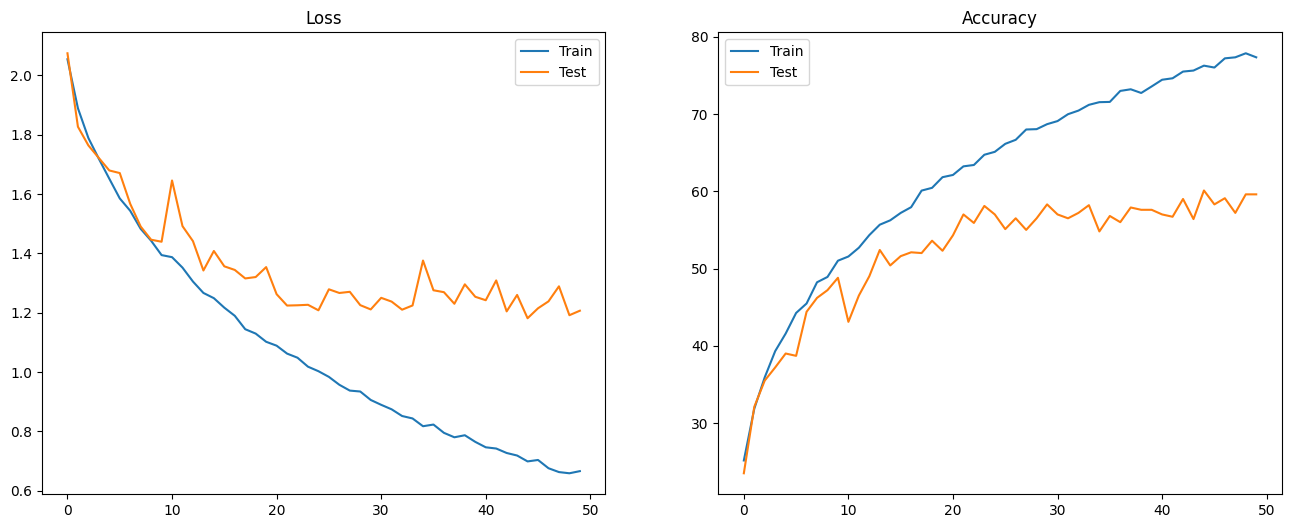

In [14]:
# ----------------------------------------
# 9. 训练过程可视化
# ----------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train')
plt.plot(test_acc_hist, label='Test')
plt.title("Accuracy")
plt.legend()
plt.show()

随机抽取 10 张测试集图片进行预测对比...


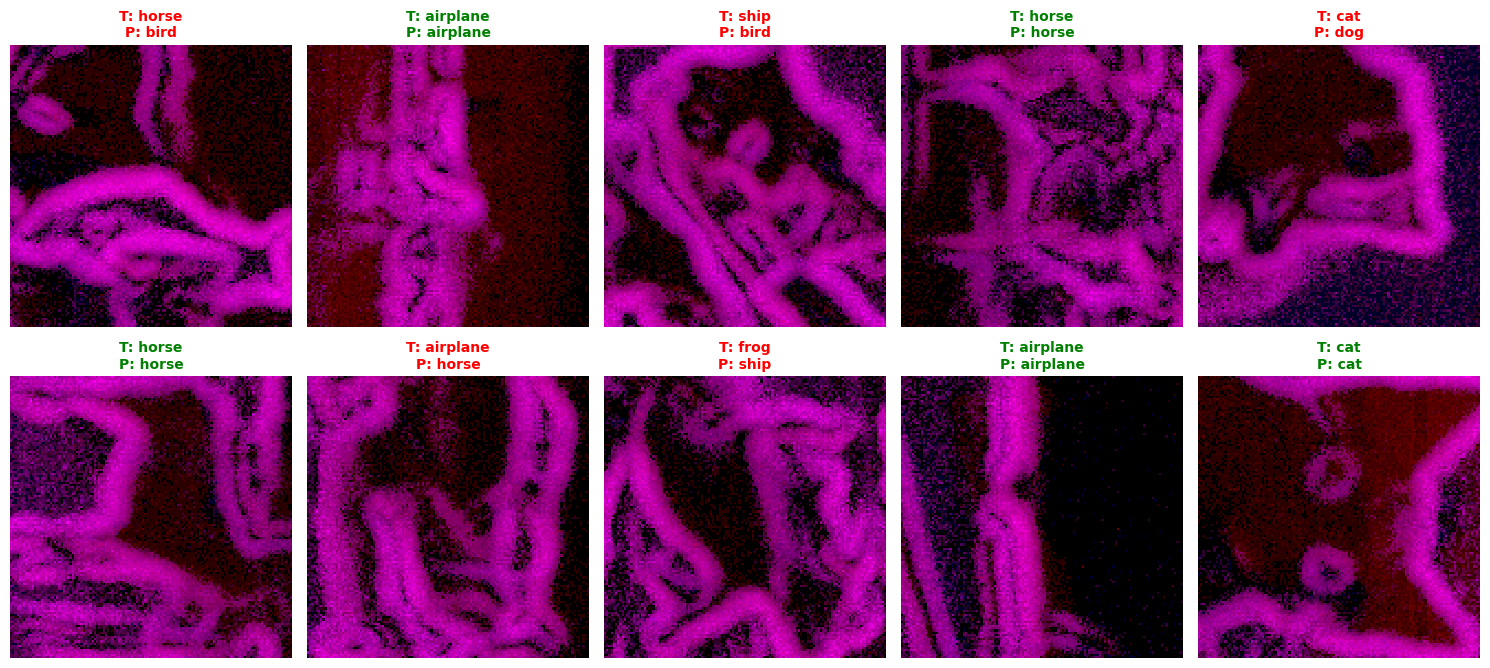

In [17]:
# ----------------------------------------
# 10. 模型预测结果随机抽样展示 (修复版)
# ----------------------------------------
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from spikingjelly.activation_based import functional

def visualize_inference(model, loader, device, num_samples=10):
    print(f"随机抽取 {num_samples} 张测试集图片进行预测对比...")
    model.eval()
    
    # 1. 从 test_loader 获取一个 batch
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # 2. 随机选择索引
    actual_batch_size = len(images)
    if actual_batch_size < num_samples:
        indices = range(actual_batch_size)
    else:
        indices = random.sample(range(actual_batch_size), num_samples)
    
    # 类别名称
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    # 3. 绘图设置
    cols = 5
    rows = (len(indices) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
    
    # 如果只有一行，axes 可能是一维数组，统一处理为二维或扁平列表
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        # 获取单张图像数据 [T, C, H, W]
        img_tensor = images[idx] 
        label_idx = labels[idx].item()
        
        # 准备模型输入: 
        # [T, C, H, W] -> [1, T, C, H, W] -> [T, 1, C, H, W]
        input_tensor = img_tensor.unsqueeze(0).permute(1, 0, 2, 3, 4).to(device)
        
        # 推理
        with torch.no_grad():
            # 【修复点】
            # 因为模型 forward 里已经有了 .mean(0)，这里出来的 output 已经是 [Batch, 10]
            # 此时 Batch = 1，所以 output shape 是 [1, 10]
            output = model(input_tensor) 
            
            # 直接取 argmax(1)
            pred_idx = output.argmax(1).item()
            
            functional.reset_net(model)
        
        # 可视化图像处理：
        vis_img = np.zeros((128, 128, 3))
        
        # 累加所有帧 [T, C, H, W] -> sum(0) -> [C, H, W]
        accumulated = img_tensor.sum(dim=0).numpy() 
        on_events = accumulated[1] # Red
        off_events = accumulated[0] # Blue
        
        vis_img[:, :, 0] = on_events
        vis_img[:, :, 2] = off_events
        
        # Log 归一化以便更好地显示
        vis_img = np.log1p(vis_img)
        if vis_img.max() > 0:
            vis_img /= vis_img.max()
            
        # 绘制
        # 兼容 axes 维度
        if hasattr(axes, 'flat'):
             ax = axes.flat[i]
        else:
             ax = axes[i] if len(indices) > 1 else axes[0]

        ax.imshow(vis_img, interpolation='nearest')
        
        # 标题颜色：绿色对，红色错
        color = 'green' if pred_idx == label_idx else 'red'
        title_text = f"T: {classes[label_idx]}\nP: {classes[pred_idx]}"
        ax.set_title(title_text, color=color, fontweight='bold', fontsize=10)
        ax.axis('off')
    
    # 隐藏多余的子图
    if hasattr(axes, 'flat'):
        for j in range(i + 1, len(axes.flat)):
            axes.flat[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# 执行可视化
visualize_inference(model, test_loader, DEVICE)

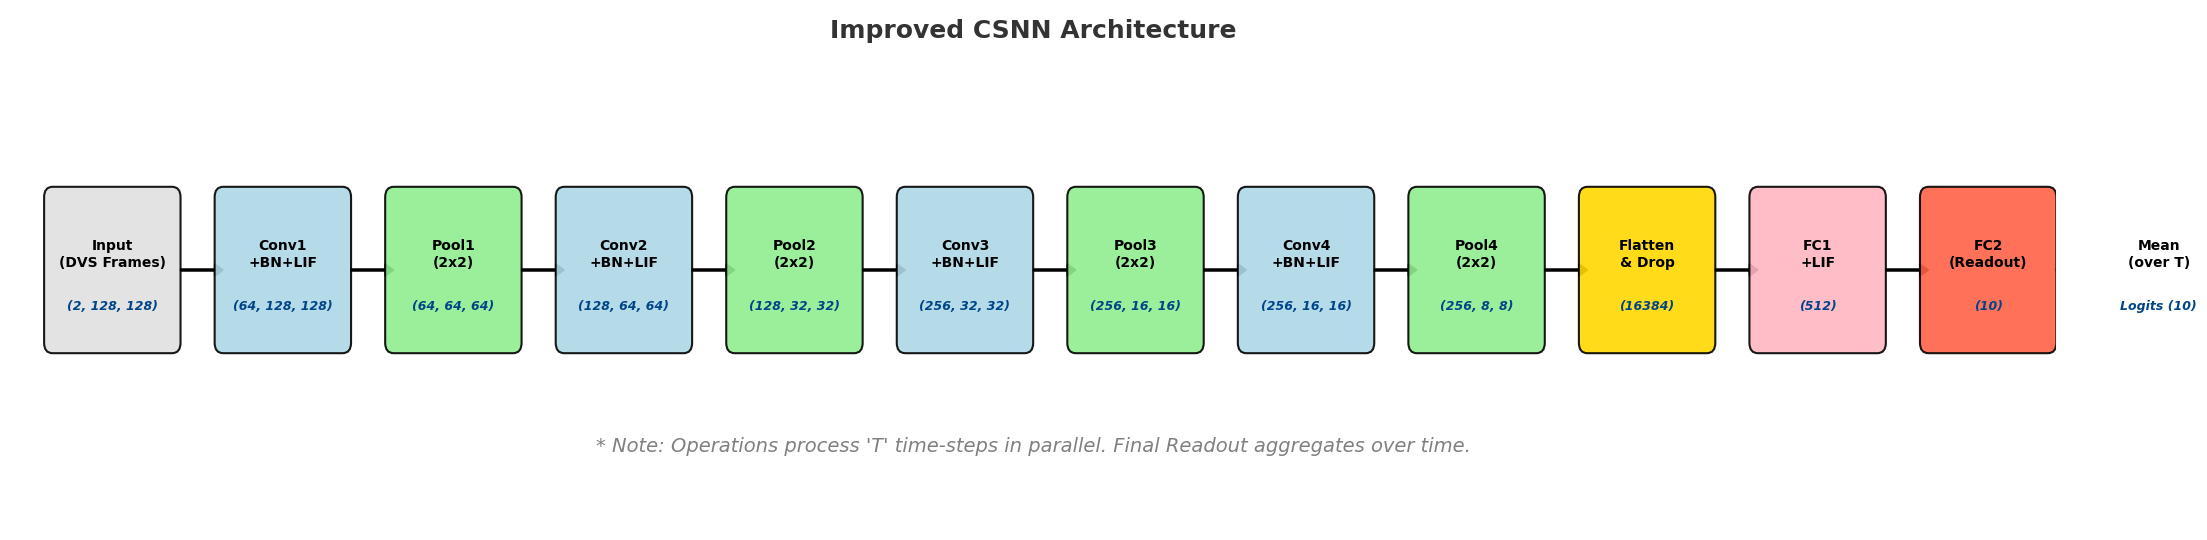

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_horizontal_architecture_final():
    # 设置画布为宽长条形 (22 x 5.5)
    fig, ax = plt.subplots(figsize=(22, 5.5))
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 5)
    ax.axis('off')
    
    # 标题 (根据您的 PPT 标题风格)
    ax.text(12, 4.8, "Improved CSNN Architecture", 
            ha='center', va='center', fontsize=18, fontweight='bold', color='#333333')
    
    # 定义层信息: (层名称, 输出形状, 颜色)
    # 形状逻辑: 128x128 -> (Pool) 64 -> 32 -> 16 -> 8
    steps = [
        ("Input\n(DVS Frames)", "(2, 128, 128)", "#e0e0e0"),       # Grey
        ("Conv1\n+BN+LIF", "(64, 128, 128)", "#add8e6"),            # Blue
        ("Pool1\n(2x2)", "(64, 64, 64)", "#90ee90"),                # Green
        ("Conv2\n+BN+LIF", "(128, 64, 64)", "#add8e6"),
        ("Pool2\n(2x2)", "(128, 32, 32)", "#90ee90"),
        ("Conv3\n+BN+LIF", "(256, 32, 32)", "#add8e6"),
        ("Pool3\n(2x2)", "(256, 16, 16)", "#90ee90"),
        ("Conv4\n+BN+LIF", "(256, 16, 16)", "#add8e6"),
        ("Pool4\n(2x2)", "(256, 8, 8)", "#90ee90"),
        ("Flatten\n& Drop", "(16384)", "#ffd700"),                  # Yellow
        ("FC1\n+LIF", "(512)", "#ffb6c1"),                          # Pink
        ("FC2\n(Readout)", "(10)", "#ff6347"),                      # Red
        ("Mean\n(over T)", "Logits (10)", "#dda0dd")                # Purple
    ]
    
    # 绘图参数
    start_x = 0.5
    y_center = 2.5
    box_width = 1.4
    box_height = 1.4
    gap = 0.4
    
    current_x = start_x
    
    for i, (text, shape, color) in enumerate(steps):
        # 1. 绘制方框
        rect = patches.FancyBboxPatch((current_x, y_center - box_height/2), 
                                      box_width, box_height, 
                                      boxstyle="round,pad=0.1", 
                                      linewidth=1.5, edgecolor='black', facecolor=color, alpha=0.9)
        ax.add_patch(rect)
        
        # 2. 添加层名称 (Box内部)
        ax.text(current_x + box_width/2, y_center + 0.15, text, 
                ha='center', va='center', fontsize=10, fontweight='bold', wrap=True)
        
        # 3. 添加形状信息 (Box内部下方，蓝色斜体)
        ax.text(current_x + box_width/2, y_center - 0.35, shape, 
                ha='center', va='center', fontsize=9, style='italic', color='#004488', fontweight='bold')
        
        # 4. 绘制箭头 (指向右侧)
        if i < len(steps) - 1:
            arrow_start_x = current_x + box_width + 0.1
            ax.arrow(arrow_start_x, y_center, gap, 0, 
                     head_width=0.12, head_length=0.1, fc='black', ec='black', width=0.02)
            
        # 更新下一个框的X坐标
        current_x += (box_width + gap + 0.2)

    # 添加额外标注：改为通用的 "T time-steps"，避免数字写死
    ax.text(12, 0.8, "* Note: Operations process 'T' time-steps in parallel. Final Readout aggregates over time.", 
            ha='center', va='center', fontsize=14, style='italic', color='gray')

    plt.tight_layout()
    # 保存高清图
    plt.savefig('snn_architecture_final.png', dpi=300, bbox_inches='tight')
    plt.show()

draw_horizontal_architecture_final()